<a href="https://colab.research.google.com/github/MasiboBrian/AirBNB-Price-Prediction/blob/master/New_Product_Recommendation_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Domain - E-commerce

# Context:

Everyday a million products are being recommended to users based on popularity and other metrics on e-commerce websites. The most popular e-commerce website boosts average order value by 50%, increases revenues by 300%, and
improves conversion. In addition to being a powerful tool for increasing revenues,product recommendations are so essential that customers now expect to see similar features on all other eCommerce sites.

# Data Description:
### Data columns:

First three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.

# Source:
Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) The repository has several datasets. For this case study, we are using the "baby" dataset.


# Objective:
To make a recommendation system that recommends at least five(5) new products based on the user's habits.

## Import the libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

## 1. Read and explore the dataset

In [ ]:
#Read dataset and add column names
df = pd.read_csv("ratings_Baby.csv", header=None)
df.columns = ['userId', 'productId','Rating','timestamp']
df.head()

,userId,productId,Rating,timestamp
0,A28O3NP6WR5517,0188399313,5.0,1369612800
1,AX0M1Z6ZWO52J,0188399399,5.0,1365465600
2,A1KD7N84L7NIUT,0188399518,4.0,1392336000
3,A29CUDEIF4X1UO,0188399518,3.0,1373241600
4,A32592TYN6C9EM,0316967297,4.0,1378425600


In [ ]:
# Display the data
df.head()

,userId,productId,Rating,timestamp
0,A28O3NP6WR5517,0188399313,5.0,1369612800
1,AX0M1Z6ZWO52J,0188399399,5.0,1365465600
2,A1KD7N84L7NIUT,0188399518,4.0,1392336000
3,A29CUDEIF4X1UO,0188399518,3.0,1373241600
4,A32592TYN6C9EM,0316967297,4.0,1378425600


In [ ]:
#Shape of the data
df.shape

(915446, 4)

In [ ]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['userId'].nunique())
print('Number of unique ITEMS in Raw data = ', df['productId'].nunique())

Number of unique USERS in Raw data =  531890
Number of unique ITEMS in Raw data =  64426


In [ ]:
# find minimum and maximum ratings
print('The minimum rating is: %d' %(df['Rating'].min()))
print('The maximum rating is: %d' %(df['Rating'].max()))

The minimum rating is: 1
The maximum rating is: 5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915446 entries, 0 to 915445
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     915446 non-null  object 
 1   productId  915446 non-null  object 
 2   Rating     915446 non-null  float64
 3   timestamp  915446 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 27.9+ MB


In [ ]:
#Check the datatypes
df.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [ ]:
# Check for missing values present
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


Ratings are on scale of 1 - 5

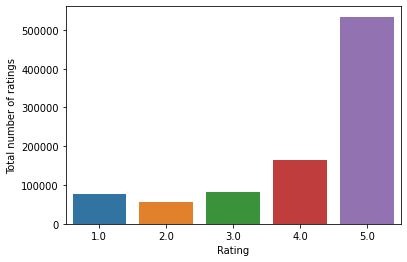

In [ ]:
sns.countplot(x = 'Rating', data = df)
plt.ylabel('Total number of ratings');

## 2. Take a subset of the dataset to make it less sparse/ denser

In [ ]:
# Top 10 users based on number of ratings given (no. of products rated by user)
most_rated = df['userId'].value_counts()
#alternate approach
#most_rated = df.groupby('userId').size().sort_values(ascending=False)
most_rated.head(10)

ARIFCL50JD5SK     155
AJGU56YG8G1DQ     140
AF8SREA2XE7BJ     122
AJC88791BZEW7     105
A276OI0NHBYORX     95
A2PNW6QDW8OPY0     93
A1M5ZT35YX6TIN     82
AYNNJ0DBGL5H7      81
A100L918633LUO     81
AOEUN9718KVRD      81
Name: userId, dtype: int64

In [ ]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(most_rated >= 50)) )


 No of rated product more than 50 per user : 62



In [ ]:
df.shape

(915446, 4)

In [ ]:
#keep the users only who has given 50 or more number of ratings
#counts = df['userId'].value_counts()
df1 = df[df['userId'].isin(most_rated[most_rated >= 50].index)]
df1.shape

(4015, 4)

In [ ]:
#Dropping the Timestamp column
df1.drop(['timestamp'], axis=1,inplace=True)

In [ ]:
df1.head()

,userId,productId,Rating
532,A10STX704CY2IH,9729375011,5.0
534,A35MDIBPAX9X7U,9729375011,5.0
738,A1M8AYAL3L8ACP,B00000IZQI,4.0
1235,AKCZIJ6ZHE41D,B00002JV9S,4.0
1328,AJGU56YG8G1DQ,B00002JXFI,5.0


In [ ]:
# Number of unique user id and product id in the data
print('Number of unique USERS in filtered data = ', df1['userId'].nunique())
print('Number of unique ITEMS in filtered data = ', df1['productId'].nunique())

Number of unique USERS in filtered data =  62
Number of unique ITEMS in filtered data =  2639


After filtering the data for the users with min 50 ratings, the number of users came less than the number of products

## 3. Build Popularity Recommender model

Popularity based (Non-personalised) recommendation system basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly.


In [ ]:
#Average rating of the product
df1.groupby('productId')['Rating'].mean().head()

productId
9729375011    5.0
B00000IZQI    4.0
B00002JV9S    4.0
B00002JXFI    5.0
B00003TKWE    4.0
Name: Rating, dtype: float64

In [ ]:
#Average rating of the product sorted in Descending order
df1.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B00JRYRYS6    5.0
B002WN20F6    5.0
B002SW3CK8    5.0
B002TIUM2W    5.0
B002TOKR7G    5.0
Name: Rating, dtype: float64

In [ ]:
#Total no of rating for product
df1.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B000IDSLOG    15
B001QC3CKG    12
B0006FHBAQ    11
B000GJIE4E    10
B00I6IGF4I    10
Name: Rating, dtype: int64

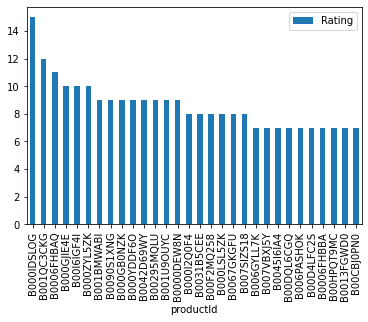

In [ ]:
popular_products = pd.DataFrame(df1.groupby('productId')['Rating'].count())
popular_products.sort_values('Rating', ascending=False).head(30).plot(kind = "bar");

In [ ]:
#Mean_ratings_count = pd.DataFrame(df1.groupby('productId')['Rating'].count())
popular_products["Mean_Ratings"] = pd.DataFrame(df1.groupby('productId')['Rating'].mean())
popular_products['Number_of_Ratings'] = pd.DataFrame(df1.groupby('productId')['Rating'].count())
popular_products.drop(['Rating'], axis=1,inplace=True)

In [ ]:
popular_products.head()

,Mean_Ratings,Number_of_Ratings
productId,,
9729375011,5.0,2
B00000IZQI,4.0,1
B00002JV9S,4.0,1
B00002JXFI,5.0,1
B00003TKWE,4.0,1


In [ ]:
# Sort Products by top mean ratings
popular_products.sort_values(['Mean_Ratings', 'Number_of_Ratings'], ascending=[False, False])[:10]

,Mean_Ratings,Number_of_Ratings
productId,,
B000I2Q0F4,5.0,8
B002L3T9YM,5.0,6
B003VLG4PK,5.0,6
B000056OV0,5.0,5
B001WAJVZM,5.0,5
B00004C8S8,5.0,4
B0009ET49K,5.0,4
B000RHJT6C,5.0,4
B002ETXCEG,5.0,4


5 star rating products are rated by very few users. We may want to recommend most popular products to the new users though the rating may be smaller

In [ ]:
popular_products['Number_of_Ratings'].min()

1

In [ ]:
popular_products['Number_of_Ratings'].max()

15

In [ ]:
Recommend = popular_products.sort_values(['Number_of_Ratings'], ascending= False)
Recommend.head(10)

,Mean_Ratings,Number_of_Ratings
productId,,
B000IDSLOG,4.333333,15
B001QC3CKG,4.250000,12
B0006FHBAQ,4.000000,11
B000GJIE4E,4.900000,10
B00I6IGF4I,4.600000,10
B000ZYL5ZK,4.400000,10
B001BMWABI,4.000000,9
B0090S1XNG,4.000000,9
B000GB0NZK,4.111111,9


Most pupular products are having average rating less that 4.5 rating

In [ ]:
#Recommending the top 10 products which are having higher then 4.5 rating and received more than 100 Ratings
Recommend[(Recommend[ "Mean_Ratings"] > 4.5) & (Recommend[ "Number_of_Ratings"] > 100)].head(10)

,Mean_Ratings,Number_of_Ratings
productId,,


### Most popular products are having lesser average rating but still higher than 4.5 rating can be recommended to a new user.

## 4. Split the data randomly into a train and test dataset.

In [ ]:
#Taking subset of the dataset to avoid memory issue for Collaborative Filtering model
df2=df1.iloc[:20000,0:]

In [ ]:
!pip install surprise
import surprise
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader # to define range of ratings
import os
from surprise.model_selection import train_test_split

     |████████████████████████████████| 11.8 MB 52 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617739 sha256=08c4b184fdc524c32aece2524fee4b776f6ea419fb4a16eb9c193e763c285bb2
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df2,reader)

In [ ]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

## 5. Build Collaborative Filtering model

Collaborative filtering (CF) Build Collaborative Filtering model (Personalised)is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. CF is based on the idea that the best recommendations come from people who have similar tastes. In other words, it uses historical item ratings of like-minded people to predict how someone would rate an item. Collaborative filtering has two sub-categories that are generally called memory based(User-User and Item-Item CF with similarity) and model-based(KNN, SVD).

### First, we are going to use User-User CF with KNN , User based CF is compact and will converge faster as the number of users came out lesser compared to number of products after filtering the data.

In [ ]:
#Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options= {'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [ ]:
test_pred

[Prediction(uid='AJC88791BZEW7', iid='B002UHJ0HK', r_ui=5.0, est=4.194306049822064, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2PNW6QDW8OPY0', iid='B001BPZHQ0', r_ui=5.0, est=4.194306049822064, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1TBWRXV7KVHPC', iid='B00B2F7DP2', r_ui=3.0, est=4.194306049822064, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AYNNJ0DBGL5H7', iid='B00GZFNHOA', r_ui=5.0, est=4.5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AF9OYN557Z77I', iid='B00794BOIW', r_ui=5.0, est=4.194306049822064, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2OKNQWLFBOGMM', iid='B0035LSPXU', r_ui=1.0, est=4.194306049822064, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AF8SREA2XE7BJ', iid='B006PASHOK', r_ui=5.0, est=4.4013

## 6. Evaluate the above model. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.)

In [ ]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.0622


1.0622325182130348

### Second, we are going to use User-User CF with KNN , User based CF is compact and will converge faster as the number of users came out lesser compared to number of products after filtering the data.

In [ ]:
#Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options= {'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
# run the trained model against the testset
test_pred1 = algo.test(testset)

In [ ]:
test_pred1

[Prediction(uid='AJC88791BZEW7', iid='B002UHJ0HK', r_ui=5.0, est=4.194306049822064, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2PNW6QDW8OPY0', iid='B001BPZHQ0', r_ui=5.0, est=4.194306049822064, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1TBWRXV7KVHPC', iid='B00B2F7DP2', r_ui=3.0, est=4.194306049822064, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AYNNJ0DBGL5H7', iid='B00GZFNHOA', r_ui=5.0, est=3.6666666666666665, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AF9OYN557Z77I', iid='B00794BOIW', r_ui=5.0, est=4.194306049822064, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2OKNQWLFBOGMM', iid='B0035LSPXU', r_ui=1.0, est=4.194306049822064, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AF8SREA2XE7BJ', iid='B006PASHOK', r_ui=

In [ ]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred1, verbose=True)

Item-based Model : Test Set
RMSE: 1.1565


1.1565082685744776

User based collaborative filtering shows less RMSE value compared to the Item based collaoborative filtering.


### Third, we are going to use Model-based collaborative filtering system (Personalised) Singular Value Decomposition using TuncatedSVD


These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

In [ ]:
df3=df1.iloc[:10000,0:]

In [ ]:
df3.shape

(4015, 3)

In [ ]:
ratings_matrix = df3.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,9729375011,B00000IZQI,B00002JV9S,B00002JXFI,B00003TKWE,B00003TL7P,B00003XAKP,B00003XAKR,B000046S3W,B0000482FA,B00004C8S8,B00004RA66,B00004TFLB,B00004TIHX,B00004W1UB,B00004YMZE,B0000537GQ,B000056HM5,B000056HMB,B000056HNX,B000056J1T,B000056J1W,B000056J2D,B000056J39,B000056J76,B000056J7K,B000056J90,B000056J9F,B000056JAK,B000056JCC,B000056JCY,B000056JHX,B000056JIE,B000056JMU,B000056OUF,B000056OUH,B000056OUO,B000056OV0,B000056OVS,B000056OWN,...,B00HCSYQVM,B00HE66NN6,B00HE66NNQ,B00HFA1Z7U,B00HG692FK,B00HG692IW,B00HG692J6,B00HHRH07U,B00HMR1JFO,B00HOVSCQW,B00HPQT9MC,B00HQMMLP2,B00HTUZPA4,B00HURFECK,B00HVDOJEW,B00HVEJV30,B00HWN37EO,B00HZ5SRLM,B00HZQO8LE,B00I0N0F2W,B00I2IA638,B00I3A4UUA,B00I3WEXPU,B00I3WEXUA,B00I3WEXX2,B00I3YFHPI,B00I3ZRPP2,B00I6IGF4I,B00I88XHGK,B00I9K5UIK,B00IAEHFH4,B00IVNEGLW,B00IYRE2W8,B00J0G2XQ4,B00J34P5A4,B00J3EQ68E,B00J3TVRSS,B00J7ICKA4,B00JEV5UM4,B00JRYRYS6
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100L918633LUO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A10STX704CY2IH,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0
A1235J5HSC60MW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A13C8QSYS8NC5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A14DNCG5WHM86Z,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


As expected, the utility matrix obtaned above is sparce, I have filled up the unknown values wth 0.

In [ ]:
ratings_matrix.shape

(62, 2639)

Transposing the matrix

In [ ]:
X = ratings_matrix.T
X.head()

userId,A100L918633LUO,A10STX704CY2IH,A1235J5HSC60MW,A13C8QSYS8NC5,A14DNCG5WHM86Z,A17VIBT0O9LTPO,A1DHKKNNW6H783,A1F7D876YNJIB3,A1M5ZT35YX6TIN,A1M8AYAL3L8ACP,A1ONB72XBGE82K,A1POD4SH35DZ3X,A1PTBXZG04GT29,A1R1BFJCMWX0Y3,A1RJTEOX6BJ1OP,A1TBWRXV7KVHPC,A1XAYSI96X8YVH,A1ZFUVIC4U6BGI,A26EQ8U96JA92T,A26WHR1IP0A250,A276OI0NHBYORX,A2974R9BTPZPOJ,A2BUPFYUOFL8WH,A2H11AT092SHRA,A2K75QOCP9ZHSL,A2K89R0B20LYHB,A2OAQHQRJQP6J7,A2OKNQWLFBOGMM,A2PNW6QDW8OPY0,A2RAHVQXI12VGA,A2RX62V4E2BF5Z,A2U6UPHSBJ0SOY,A2V5LXYJAFWTOW,A30S2XWHFQZ8X0,A33BIN0VIKPF3A,A35MDIBPAX9X7U,A35THDE2CLWTDC,A38WJTLTZM2P85,A3FMPT5IH0CJ50,A3I43PYBXWCKNW,A3KHIBFERCW890,A3NXCL9NJTL3TF,A3RGN75LHYAG8U,A3UORBSIKQ56ZB,A8PP8NPRJSAKO,A91TB0WX94MHP,AEK5GOE7UFP2P,AF8SREA2XE7BJ,AF9OYN557Z77I,AHK9Z99W9UQE0,AJC88791BZEW7,AJGU56YG8G1DQ,AKCZIJ6ZHE41D,AM29FF4K9EKVN,AOEUN9718KVRD,AOQ2IB802NXAQ,AOTMP0OKJOUWI,AQYH2DHP78S83,AQYYUN3T7B0WM,ARIFCL50JD5SK,AYNNJ0DBGL5H7,AZAC8O310IK4E
productId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9729375011,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B00000IZQI,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B00002JV9S,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
B00002JXFI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0
B00003TKWE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0


In [ ]:
X.shape

(2639, 62)

Unique products in subset of data

In [ ]:
X1 = X

In [ ]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(2639, 10)

In [ ]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(2639, 2639)

In [ ]:
X.head()

userId,A100L918633LUO,A10STX704CY2IH,A1235J5HSC60MW,A13C8QSYS8NC5,A14DNCG5WHM86Z,A17VIBT0O9LTPO,A1DHKKNNW6H783,A1F7D876YNJIB3,A1M5ZT35YX6TIN,A1M8AYAL3L8ACP,A1ONB72XBGE82K,A1POD4SH35DZ3X,A1PTBXZG04GT29,A1R1BFJCMWX0Y3,A1RJTEOX6BJ1OP,A1TBWRXV7KVHPC,A1XAYSI96X8YVH,A1ZFUVIC4U6BGI,A26EQ8U96JA92T,A26WHR1IP0A250,A276OI0NHBYORX,A2974R9BTPZPOJ,A2BUPFYUOFL8WH,A2H11AT092SHRA,A2K75QOCP9ZHSL,A2K89R0B20LYHB,A2OAQHQRJQP6J7,A2OKNQWLFBOGMM,A2PNW6QDW8OPY0,A2RAHVQXI12VGA,A2RX62V4E2BF5Z,A2U6UPHSBJ0SOY,A2V5LXYJAFWTOW,A30S2XWHFQZ8X0,A33BIN0VIKPF3A,A35MDIBPAX9X7U,A35THDE2CLWTDC,A38WJTLTZM2P85,A3FMPT5IH0CJ50,A3I43PYBXWCKNW,A3KHIBFERCW890,A3NXCL9NJTL3TF,A3RGN75LHYAG8U,A3UORBSIKQ56ZB,A8PP8NPRJSAKO,A91TB0WX94MHP,AEK5GOE7UFP2P,AF8SREA2XE7BJ,AF9OYN557Z77I,AHK9Z99W9UQE0,AJC88791BZEW7,AJGU56YG8G1DQ,AKCZIJ6ZHE41D,AM29FF4K9EKVN,AOEUN9718KVRD,AOQ2IB802NXAQ,AOTMP0OKJOUWI,AQYH2DHP78S83,AQYYUN3T7B0WM,ARIFCL50JD5SK,AYNNJ0DBGL5H7,AZAC8O310IK4E
productId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9729375011,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B00000IZQI,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B00002JV9S,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
B00002JXFI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0
B00003TKWE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0


In [ ]:
X.index[1000]

'B0028K2RMO'

Index # of product ID purchased by customer

In [ ]:
i = "B0028K2RMO"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

1000

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(2639,)

In [ ]:
correlation_product_ID[0:10]

array([ 0.49818452,  0.11992805,  0.91535757, -0.1894101 ,  0.91535757,
        0.4939924 , -0.13038175, -0.1894101 ,  0.05850887,  0.36412285])

Recommending top 5 highly correlated products in sequence

In [ ]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i)

Recommend[0:5]

['B00002JV9S', 'B00003TKWE', 'B00004RA66', 'B00004TIHX', 'B000056HM5']

In [ ]:
X.index[2000]

'B00622Y09C'

In [ ]:
i = "B00622Y09C"
product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

2000

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(2639,)

In [ ]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i)

Recommend[0:5]

['B0000482FA', 'B00004RA66', 'B00004TIHX', 'B000056HMB', 'B000056J1T']

The Popularity-based recommender system is non-personalised and the recommendations are based on frequency counts, which may be not suitable to the user. The Popularity based model recommendeds the same set of 5 products to all.

Collaborative Filtering based model identifies the correlated products based on users ratings and suggest entire different list based on the user past purchase history. Model based collaborative filtering model (SVD method) identified the top 5 highly correlated products based on the user ratings. We can see the correlated products for product ids 1000 & 2000, the recoomendations are different.

## 7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [ ]:
def filterData(fileName):
    df=pd.read_csv(fileName,names=['userId', 'productId','Rating','timestamp'])
    most_rated = df['userId'].value_counts()
    return df[df['userId'].isin(most_rated[most_rated >= 50].index)]

In [ ]:
global df_50
df_50 = filterData("ratings_Baby.csv")
print(df_50.shape)
#df_50.head()

(4015, 4)


In [ ]:
def extractPivot(df_x):
    global user_index
    # creating the pivot matrix of userId and productId
    pivot_df = df_x.pivot(index = 'userId', columns ='productId', values = 'Rating').fillna(0)
    user_index =pivot_df.index.tolist()
    return pivot_df

In [ ]:
print(extractPivot(df_50).shape)
extractPivot(df_50).head()

(62, 2639)


productId,9729375011,B00000IZQI,B00002JV9S,B00002JXFI,B00003TKWE,B00003TL7P,B00003XAKP,B00003XAKR,B000046S3W,B0000482FA,B00004C8S8,B00004RA66,B00004TFLB,B00004TIHX,B00004W1UB,B00004YMZE,B0000537GQ,B000056HM5,B000056HMB,B000056HNX,B000056J1T,B000056J1W,B000056J2D,B000056J39,B000056J76,B000056J7K,B000056J90,B000056J9F,B000056JAK,B000056JCC,B000056JCY,B000056JHX,B000056JIE,B000056JMU,B000056OUF,B000056OUH,B000056OUO,B000056OV0,B000056OVS,B000056OWN,...,B00HCSYQVM,B00HE66NN6,B00HE66NNQ,B00HFA1Z7U,B00HG692FK,B00HG692IW,B00HG692J6,B00HHRH07U,B00HMR1JFO,B00HOVSCQW,B00HPQT9MC,B00HQMMLP2,B00HTUZPA4,B00HURFECK,B00HVDOJEW,B00HVEJV30,B00HWN37EO,B00HZ5SRLM,B00HZQO8LE,B00I0N0F2W,B00I2IA638,B00I3A4UUA,B00I3WEXPU,B00I3WEXUA,B00I3WEXX2,B00I3YFHPI,B00I3ZRPP2,B00I6IGF4I,B00I88XHGK,B00I9K5UIK,B00IAEHFH4,B00IVNEGLW,B00IYRE2W8,B00J0G2XQ4,B00J34P5A4,B00J3EQ68E,B00J3TVRSS,B00J7ICKA4,B00JEV5UM4,B00JRYRYS6
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100L918633LUO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10STX704CY2IH,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
A1235J5HSC60MW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A13C8QSYS8NC5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A14DNCG5WHM86Z,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def replaceIndex(df_x):
    global def_index
    pivot_df = extractPivot(df_x)
    pivot_df['def_index'] = np.arange(0, pivot_df.shape[0],1) # adding index column to the matrix
    pivot_df1 = pivot_df.set_index(['def_index'])# after replacing first column with index column
    def_index = pivot_df1.index.tolist()
    return pivot_df1

In [ ]:
print(replaceIndex(df_50).shape)
replaceIndex(df_50).head()

(62, 2639)


productId,9729375011,B00000IZQI,B00002JV9S,B00002JXFI,B00003TKWE,B00003TL7P,B00003XAKP,B00003XAKR,B000046S3W,B0000482FA,B00004C8S8,B00004RA66,B00004TFLB,B00004TIHX,B00004W1UB,B00004YMZE,B0000537GQ,B000056HM5,B000056HMB,B000056HNX,B000056J1T,B000056J1W,B000056J2D,B000056J39,B000056J76,B000056J7K,B000056J90,B000056J9F,B000056JAK,B000056JCC,B000056JCY,B000056JHX,B000056JIE,B000056JMU,B000056OUF,B000056OUH,B000056OUO,B000056OV0,B000056OVS,B000056OWN,...,B00HCSYQVM,B00HE66NN6,B00HE66NNQ,B00HFA1Z7U,B00HG692FK,B00HG692IW,B00HG692J6,B00HHRH07U,B00HMR1JFO,B00HOVSCQW,B00HPQT9MC,B00HQMMLP2,B00HTUZPA4,B00HURFECK,B00HVDOJEW,B00HVEJV30,B00HWN37EO,B00HZ5SRLM,B00HZQO8LE,B00I0N0F2W,B00I2IA638,B00I3A4UUA,B00I3WEXPU,B00I3WEXUA,B00I3WEXX2,B00I3YFHPI,B00I3ZRPP2,B00I6IGF4I,B00I88XHGK,B00I9K5UIK,B00IAEHFH4,B00IVNEGLW,B00IYRE2W8,B00J0G2XQ4,B00J34P5A4,B00J3EQ68E,B00J3TVRSS,B00J7ICKA4,B00JEV5UM4,B00JRYRYS6
def_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
dict_ = {}
for i in def_index:
    dict_[i] = user_index[i]
#dict_

In [ ]:
dict_[10]

'A1ONB72XBGE82K'

In [ ]:
from scipy.sparse.linalg import svds

In [ ]:
def calculateSVD(df_x):
    pivot_df1 = replaceIndex(df_x)
    # Singular Value Decomposition to extract U, Sigma, Vt
    U, Sigma, Vt = svds(pivot_df1, k = 10) # k is the number of concepts
    # Construct diagonal array in SVD
    #print("Sigma Array:",Sigma)
    S = np.diag(Sigma) # convert python resultant sigma array to sigma diagonal matrix
    #print("Sigma_Diag_Matrix:",S)
    return U, S, Vt

In [ ]:
calculateSVD(df_50)

(array([[-9.32043832e-02,  3.04107271e-01, -2.64570840e-01,
          5.81784797e-01, -3.40355499e-01,  3.98671026e-01,
          3.54434452e-01, -1.09445898e-01, -5.16882321e-02,
         -1.06068069e-01],
        [-1.38440338e-02, -7.37245089e-03, -6.31615462e-02,
          2.59850239e-02, -4.97254931e-02, -5.55727667e-02,
          9.01231645e-03, -4.39850562e-02,  6.55439082e-03,
         -7.76695044e-02],
        [ 1.59421291e-01, -2.42577545e-01,  4.80532821e-02,
          1.35574419e-02, -1.08869314e-01,  5.97788697e-02,
          3.62894743e-02, -8.67068036e-02, -3.55726796e-02,
         -7.89485139e-02],
        [ 1.14903837e-02, -4.01237564e-02, -2.52850309e-02,
         -6.65562957e-03,  2.07838190e-02,  2.23150174e-03,
          1.22101949e-03, -3.80544757e-02, -1.12082137e-02,
         -2.73531622e-02],
        [-2.23928799e-02, -6.18326518e-02,  2.14117334e-03,
          1.53974339e-03, -7.55596618e-03,  1.33289379e-03,
         -2.50051878e-02, -1.38041758e-02, -1.984928

In [ ]:
def predictions(df_x):
    pivot_df1 = replaceIndex(df_x)
    U,S,Vt = calculateSVD(df_x)
    preds_df = pd.DataFrame(np.dot(np.dot(U,S),Vt), columns = pivot_df1.columns)
    mean_actual= pivot_df1.mean()
    mean_pred = preds_df.mean()
    rmse_df = pd.concat([pivot_df1.mean(), preds_df.mean()], axis=1)
    rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
    return pivot_df1, preds_df, rmse_df

In [ ]:
pivot_df1, preds_df, rmse_df = predictions(df_50)

In [ ]:
pivot_df1.mean().head()

productId
9729375011    0.161290
B00000IZQI    0.064516
B00002JV9S    0.064516
B00002JXFI    0.080645
B00003TKWE    0.064516
dtype: float64

In [ ]:
preds_df.mean().head()

productId
9729375011    0.072191
B00000IZQI    0.008015
B00002JV9S    0.119180
B00002JXFI    0.085405
B00003TKWE    0.119180
dtype: float64

In [ ]:
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1) # you can remove it
print(rmse_df.shape)
rmse_df.head()

(2639, 3)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
9729375011,0.161290,0.072191,0
B00000IZQI,0.064516,0.008015,1
B00002JV9S,0.064516,0.119180,2
B00002JXFI,0.080645,0.085405,3
B00003TKWE,0.064516,0.119180,4


In [ ]:
from  sklearn.metrics import mean_squared_error

In [ ]:
RMSE = (mean_squared_error(rmse_df.Avg_actual_ratings, rmse_df.Avg_predicted_ratings))**0.5
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.04003424826217119 



In [ ]:
pivot_df1.head()

productId,9729375011,B00000IZQI,B00002JV9S,B00002JXFI,B00003TKWE,B00003TL7P,B00003XAKP,B00003XAKR,B000046S3W,B0000482FA,B00004C8S8,B00004RA66,B00004TFLB,B00004TIHX,B00004W1UB,B00004YMZE,B0000537GQ,B000056HM5,B000056HMB,B000056HNX,B000056J1T,B000056J1W,B000056J2D,B000056J39,B000056J76,B000056J7K,B000056J90,B000056J9F,B000056JAK,B000056JCC,B000056JCY,B000056JHX,B000056JIE,B000056JMU,B000056OUF,B000056OUH,B000056OUO,B000056OV0,B000056OVS,B000056OWN,...,B00HCSYQVM,B00HE66NN6,B00HE66NNQ,B00HFA1Z7U,B00HG692FK,B00HG692IW,B00HG692J6,B00HHRH07U,B00HMR1JFO,B00HOVSCQW,B00HPQT9MC,B00HQMMLP2,B00HTUZPA4,B00HURFECK,B00HVDOJEW,B00HVEJV30,B00HWN37EO,B00HZ5SRLM,B00HZQO8LE,B00I0N0F2W,B00I2IA638,B00I3A4UUA,B00I3WEXPU,B00I3WEXUA,B00I3WEXX2,B00I3YFHPI,B00I3ZRPP2,B00I6IGF4I,B00I88XHGK,B00I9K5UIK,B00IAEHFH4,B00IVNEGLW,B00IYRE2W8,B00J0G2XQ4,B00J34P5A4,B00J3EQ68E,B00J3TVRSS,B00J7ICKA4,B00JEV5UM4,B00JRYRYS6
def_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
preds_df.head()

productId,9729375011,B00000IZQI,B00002JV9S,B00002JXFI,B00003TKWE,B00003TL7P,B00003XAKP,B00003XAKR,B000046S3W,B0000482FA,B00004C8S8,B00004RA66,B00004TFLB,B00004TIHX,B00004W1UB,B00004YMZE,B0000537GQ,B000056HM5,B000056HMB,B000056HNX,B000056J1T,B000056J1W,B000056J2D,B000056J39,B000056J76,B000056J7K,B000056J90,B000056J9F,B000056JAK,B000056JCC,B000056JCY,B000056JHX,B000056JIE,B000056JMU,B000056OUF,B000056OUH,B000056OUO,B000056OV0,B000056OVS,B000056OWN,...,B00HCSYQVM,B00HE66NN6,B00HE66NNQ,B00HFA1Z7U,B00HG692FK,B00HG692IW,B00HG692J6,B00HHRH07U,B00HMR1JFO,B00HOVSCQW,B00HPQT9MC,B00HQMMLP2,B00HTUZPA4,B00HURFECK,B00HVDOJEW,B00HVEJV30,B00HWN37EO,B00HZ5SRLM,B00HZQO8LE,B00I0N0F2W,B00I2IA638,B00I3A4UUA,B00I3WEXPU,B00I3WEXUA,B00I3WEXX2,B00I3YFHPI,B00I3ZRPP2,B00I6IGF4I,B00I88XHGK,B00I9K5UIK,B00IAEHFH4,B00IVNEGLW,B00IYRE2W8,B00J0G2XQ4,B00J34P5A4,B00J3EQ68E,B00J3TVRSS,B00J7ICKA4,B00JEV5UM4,B00JRYRYS6
0,0.457120,-0.029575,-0.377879,-0.018269,-0.377879,0.181555,0.237790,-0.018269,0.117388,0.195477,0.471952,0.019976,-0.039082,0.204123,-0.036969,-0.038892,0.067808,-0.180396,0.085306,-0.038892,0.039095,0.034981,-0.038892,0.010836,0.140997,-0.180661,-0.058807,0.024970,-0.031114,-0.038892,0.062435,0.019976,-0.061577,-0.014493,0.156381,0.177207,0.138984,0.153547,0.039095,-0.023335,...,0.119701,-0.022335,0.195016,-0.021687,0.241557,0.110717,-0.021620,-0.015557,0.047389,0.012110,-0.078137,0.188904,-0.016215,-0.112217,0.004952,-0.034604,0.078981,0.375500,0.025774,0.041565,0.244088,-0.038390,0.019710,-0.098248,-0.152163,0.118741,-0.053027,-0.204759,0.188904,0.188904,-0.252007,0.279498,0.148426,0.188904,0.207768,-0.021620,-0.028635,0.148426,-0.029874,-0.129654
1,0.159185,0.004698,0.076073,0.159167,0.076073,0.084903,0.218410,0.159167,0.004881,0.034054,0.508109,0.013327,0.023985,0.069330,0.005872,0.034191,0.020678,0.072273,0.032719,0.034191,0.006811,0.041555,0.034191,0.006353,0.056099,0.034452,0.027824,0.016658,0.027353,0.034191,0.017126,0.013327,-0.013453,0.139012,0.027243,0.193221,0.227002,0.228984,0.006811,0.020514,...,0.263402,0.359406,0.181606,0.018168,0.187702,0.114954,-0.002119,0.013676,-0.014092,0.114798,0.317749,0.032927,-0.001589,0.071596,-0.145991,-0.001557,-0.023486,0.035071,0.011400,-0.020908,0.104614,0.316470,0.200401,0.029903,0.038190,0.013042,0.154772,0.890273,0.032927,0.032927,0.034928,0.353791,0.016302,0.032927,0.092815,-0.002119,0.132394,0.016302,0.079873,-0.025070
2,0.058535,0.032574,0.450135,-0.043674,0.450135,0.038562,0.196655,-0.043674,0.126900,0.026164,0.221528,0.138059,0.033439,0.279320,0.040717,-0.160175,-0.098721,0.558758,0.208636,-0.160175,0.005233,-0.007684,-0.160175,0.061664,0.320287,0.152913,0.073447,0.172573,-0.128140,-0.160175,0.039714,0.138059,-0.009496,0.676491,0.020931,-0.017511,0.110554,1.424779,0.005233,-0.096105,...,-0.175576,-0.011621,-0.172997,0.056998,-0.094193,0.061327,-0.155468,-0.064070,-0.240952,-0.016418,0.151028,0.170575,-0.116601,-0.222205,0.455817,-0.037011,-0.401587,0.171138,0.044619,-0.476737,-0.357154,-0.282599,-0.244892,-0.004762,-0.066748,0.034814,0.039314,0.006885,0.170575,0.170575,0.261985,-0.161473,0.043517,0.170575,0.045148,-0.155468,-0.004652,0.043517,-0.066396,-0.210161
3,0.017574,-0.000718,0.099001,-0.017772,0.099001,0.036700,0.020535,-0.017772,0.016661,0.005455,-0.025259,0.022569,0.003085,0.056377,-0.000898,0.003034,-0.009939,0.089101,0.030091,0.003034,0.001091,0.002874,0.003034,0.005676,0.043535,0.040101,0.018233,0.028211,0.002427,0.003034,0.007431,0.022569,-0.005541,0.114737,0.004364,-0.012317,0.171365,0.218320,0.001091,0.001820,...,0.092690,-0.070723,0.059500,0.020101,0.062719,0.016325,-0.014397,0.001214,-0.023931,0.044815,0.110571,0.030583,-0.010798,0.004595,0.008781,-0.001240,-0.039886,0.018663,0.004441,-0.046306,0.013750,-0.079087,0.060892,0.002460,0.011694,0.013190,0.049956,0.207012,0.030583,0.030583,0.016025,0.122211,0.016487,0.030583,0.020696,-0.014397,-0.030625,0.016487,-0.014099,-0.027232
4,0.045102,0.008405,0.158675,0.055110,0.158675,0.107908,0.121835,0.055110,0.023001,0.016405,0.264411,

From the comparison of above two tables, for all the sparse ratings in the original matrix, algoritm has predicted the ratings based on the available user ratings.

In [ ]:
predictions(df_50)

(productId  9729375011  B00000IZQI  ...  B00JEV5UM4  B00JRYRYS6
 def_index                          ...                        
 0                 0.0         0.0  ...         0.0         0.0
 1                 5.0         0.0  ...         0.0         0.0
 2                 0.0         0.0  ...         0.0         0.0
 3                 0.0         0.0  ...         0.0         0.0
 4                 0.0         0.0  ...         0.0         0.0
 ...               ...         ...  ...         ...         ...
 57                0.0         0.0  ...         0.0         0.0
 58                0.0         0.0  ...         2.0         0.0
 59                0.0         0.0  ...         0.0         0.0
 60                0.0         0.0  ...         0.0         0.0
 61                0.0         0.0  ...         0.0         0.0
 
 [62 rows x 2639 columns],
 productId  9729375011  B00000IZQI  ...  B00JEV5UM4  B00JRYRYS6
 0            0.457120   -0.029575  ...   -0.029874   -0.129654
 1         

In [ ]:
def recommend_items(userID, num_recommendations, fileName):

    df_50 = filterData(fileName)
    pivot_df1, preds_df, rmse_df = predictions(df_50)

    user_idx = userID-1 # index starts at 0

    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df1.iloc[user_idx].sort_values(ascending=False) #user_idx is the row number
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']

    temp = temp.loc[temp.user_ratings == 0]   # why 0? because these are the products the user has not rated, so we
    # have to recommend from these to him
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))


In [ ]:
userID = 10
print("User_Name:", dict_[userID-1])
n = 5
fileName="ratings_Baby.csv"
df_recom = recommend_items(userID, n, fileName)

User_Name: A1M8AYAL3L8ACP

Below are the recommended items for user(user_id = 10):

                   user_ratings  user_predictions
Recommended Items                                
B000IDSLOG                  0.0          0.366754
B0000DEW8N                  0.0          0.276359
B000RFCXIK                  0.0          0.255580
B00004C8S8                  0.0          0.246544
B003939VGE                  0.0          0.245281


In [ ]:
userID = 15
print("User_Name:", dict_[userID-1])
n = 5
fileName="ratings_Baby.csv"
df_recom = recommend_items(userID, n, fileName)

User_Name: A1RJTEOX6BJ1OP

Below are the recommended items for user(user_id = 15):

                   user_ratings  user_predictions
Recommended Items                                
B000YDDF6O                  0.0          0.573753
B000GJIE4E                  0.0          0.474527
B000IDSLOG                  0.0          0.455143
B0042D69WY                  0.0          0.400009
B0067GKGFU                  0.0          0.394176


## 8. Summary

The Popularity-based recommender system is non-personalised and the recommendations are based on frequency counts, which may be not suitable to the user. The Popularity based model recommendeds the same set of 5 products to all.

Collaborative Filtering is a personalised recommender system and it identifies the correlated products based on users ratings/past behavior of the user and suggests entire different list based on the user past purchase history. Model based collaborative filtering model (SVD method) identified the top 5 highly correlated products based on the user ratings.

In the above exercize, model has predicted the ratings for all the products with no ratings and recommneded 5 completely different products for the User IDs 10 and 1000 based on other user-item ratings.